<a href="https://colab.research.google.com/github/mohammad2682/Covid-19/blob/master/CNN_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [37]:
!git clone https://github.com/mohammad2682/Covid19-Dataset

fatal: destination path 'Covid19-Dataset' already exists and is not an empty directory.


In [18]:
disease_types=['COVID', 'non-COVID']
data_dir = 'Covid19-Dataset/Covid-19-Dataset/train'
train_dir = os.path.join(data_dir)

In [19]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

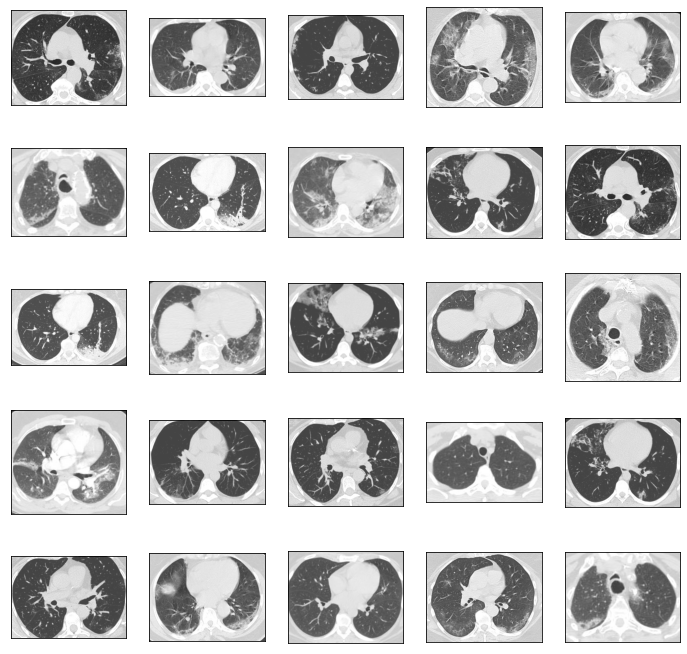

In [21]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

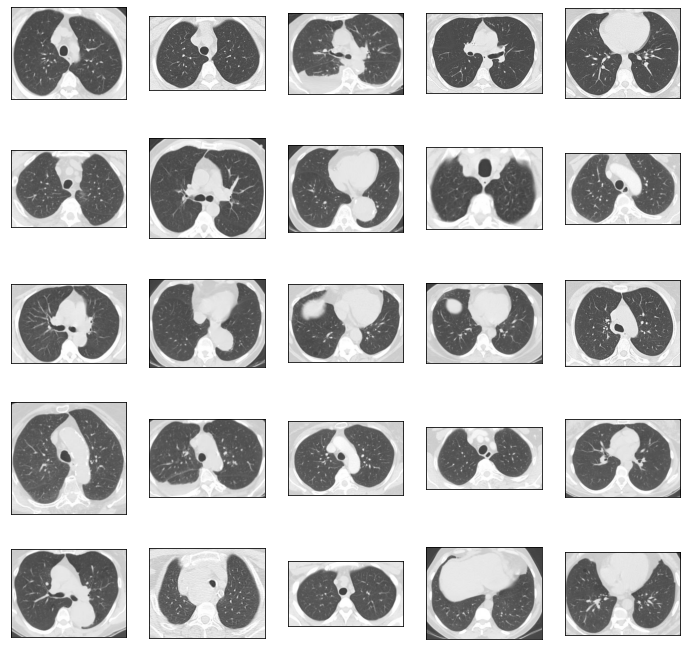

In [22]:
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

In [23]:
IMAGE_SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [24]:
from tqdm import tqdm
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2000it [00:07, 265.17it/s]


Train Shape: (2000, 128, 128, 3)


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
from keras.layers import MaxPooling2D
from keras.optimizers import Adam

In [26]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [27]:
BATCH_SIZE = 32
SEED = 42

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

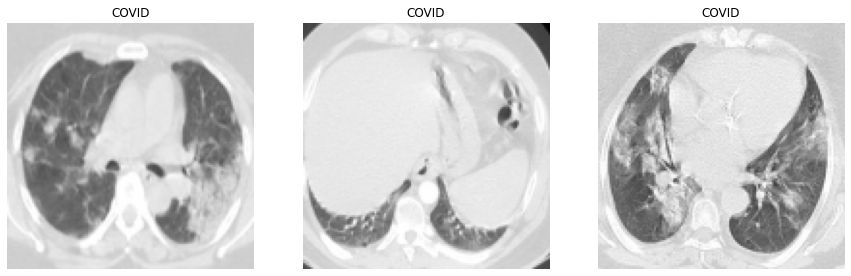

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [29]:
EPOCHS = 50
SIZE=128
N_ch=3

In [30]:
# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (7, 7), input_shape = (SIZE, SIZE, N_ch), activation =  'relu'))
classifier.add(Dropout(0.3))
#classifier.add(BatchNormalization())
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(64, (7, 7), activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a third convolutional layer
classifier.add(Conv2D(128, (7, 7), activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
#classifier.add(AveragePooling2D(pool_size = (2, 2)))
#classifier.add(GlobalAveragePooling2D())
#Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dropout(0.3))
classifier.add(Dense(units = 2, activation = 'softmax'))
# Compiling the CNN
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 122, 122, 32)      4736      
_________________________________________________________________
dropout_5 (Dropout)          (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 55, 55, 64)        100416    
_________________________________________________________________
dropout_6 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 128)      

In [31]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

In [16]:
history = classifier.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/50
 - 13s - loss: 0.7041 - accuracy: 0.4881 - val_loss: 0.6907 - val_accuracy: 0.5050

Epoch 00001: val_loss improved from inf to 0.69073, saving model to model.h5
Epoch 2/50
 - 7s - loss: 0.6925 - accuracy: 0.5106 - val_loss: 0.6922 - val_accuracy: 0.5500

Epoch 00002: val_loss did not improve from 0.69073
Epoch 3/50
 - 7s - loss: 0.6866 - accuracy: 0.5381 - val_loss: 0.6876 - val_accuracy: 0.6350

Epoch 00003: val_loss improved from 0.69073 to 0.68761, saving model to model.h5
Epoch 4/50
 - 7s - loss: 0.6847 - accuracy: 0.5381 - val_loss: 0.6893 - val_accuracy: 0.5850

Epoch 00004: val_loss did not improve from 0.68761
Epoch 5/50
 - 7s - loss: 0.6865 - accuracy: 0.5331 - val_loss: 0.6858 - val_accuracy: 0.6025

Epoch 00005: val_loss improved from 0.68761 to 0.68576, saving model to model.h5
Epoch 6/50
 - 8s - loss: 0.6861 - accuracy: 0.5456 - val_loss: 0.6904 - val_accuracy: 0.5025

Epoch 00006: val_loss did not improve from 0.68576
Epoch 7/50
 - 8s - loss: 0.6839 - accuracy:

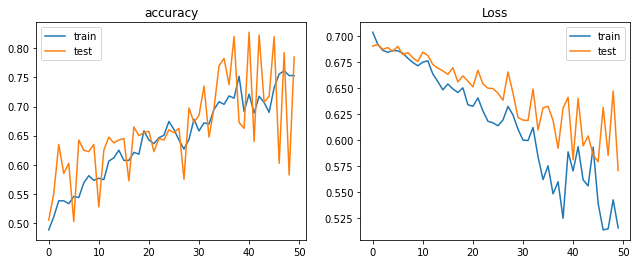

In [32]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.title('accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('Loss')
plt.legend()
plt.subplots_adjust(right = 1.5)
plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

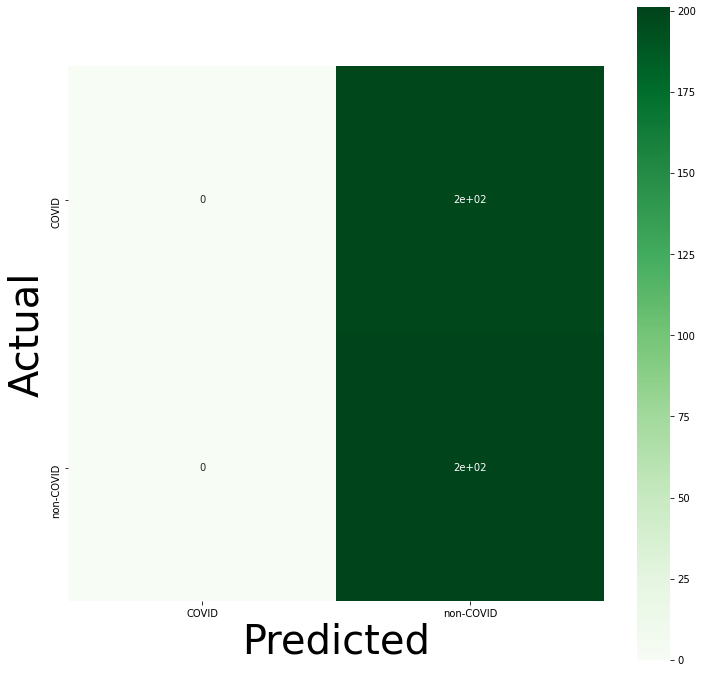

In [33]:
Y_pred = classifier.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [34]:
result = classifier.predict(X_val)
r = abs(np.round(result)-Y_val).sum()
(400-r)/400

0.005

In [35]:
result = classifier.predict(X_train)
r = abs(np.round(result)-Y_train).sum()
(1600-r)/1600

-0.00125

# add f1 score and roc


In [ ]:

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)

In [ ]:

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)


In [ ]:
# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)